
# Backtrader SMA Cross Backtest (Notebook Version)

此 Notebook 會：
- 建立 `strategy/ma_cross.py`（跨越價格與 SMA 的策略，含 `notify_trade` 紀錄淨損益）
- 下載 AAPL 日線資料（yfinance）
- 在 Backtrader 中回測，加入 Sizer 與 Analyzers
- 正確地保存繪圖、交易紀錄與摘要到 `backtest_results/`

> 若需改為其他標的或期間，請調整「參數設定」儲存格。


In [1]:

# Create strategy/ma_cross.py (self-contained repo for this notebook)
import os
os.makedirs("strategy", exist_ok=True)

strategy_code = r'''# -*- coding: utf-8 -*-
"""
MaCrossStrategy: Price-SMA crossover strategy using Backtrader.

- Buy when close crosses above SMA(period).
- Sell when close crosses below SMA(period).
- Record closed trades via notify_trade to capture net PnL after commissions.
"""

import backtrader as bt


class MaCrossStrategy(bt.Strategy):
    params = (
        ("ma_period", 20),  # SMA lookback period
    )

    def __init__(self):
        # --- Indicators ---
        # Simple Moving Average on close
        self.sma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.p.ma_period
        )
        # CrossOver indicator: >0 up-cross, <0 down-cross, 0 no cross
        self.crossover = bt.ind.CrossOver(self.data.close, self.sma)

        # --- Storage for closed trades ---
        # We record closed trades in notify_trade to ensure PnL includes commissions
        self.trades = []

    def next(self):
        """Strategy logic executed on each bar."""
        # Enter long on upward cross
        if not self.position and self.crossover[0] > 0:
            self.buy()

        # Exit long on downward cross
        elif self.position and self.crossover[0] < 0:
            self.sell()

    def notify_trade(self, trade):
        """Called by Backtrader when a trade is updated. We record results when closed."""
        if trade.isclosed:
            # Convert bt numeric datetimes to Python datetime (tz-naive)
            dt_open = bt.num2date(trade.dtopen).replace(tzinfo=None)
            dt_close = bt.num2date(trade.dtclose).replace(tzinfo=None)

            # Derive implied exit price if size != 0 (for documentation)
            exit_price = (
                trade.price + (trade.pnl / abs(trade.size))
                if trade.size != 0
                else None
            )

            self.trades.append(
                {
                    "entry_time": dt_open,
                    "exit_time": dt_close,
                    "size": trade.size,
                    "entry_price": trade.price,     # average entry price
                    "exit_price": exit_price,       # implied average exit price
                    "gross_pnl": trade.pnl,         # before commissions
                    "net_pnl": trade.pnlcomm,       # after commissions
                    "commission": trade.commission, # total commissions
                }
            )

    # Optional: monitor orders for debugging (kept minimal and safe)
    def notify_order(self, order):
        """Keep this minimal; we rely on notify_trade for PnL.
        Useful hooks for debugging order states.
        """
        if order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(
                f"Order {order.ref} not completed: status={order.getstatusname()}"
            )

    def log(self, txt):
        """Simple logger for debugging."""
        dt = self.datas[0].datetime.datetime(0)
        print(f"[{dt}] {txt}")
'''
with open("strategy/ma_cross.py", "w", encoding="utf-8") as f:
    f.write(strategy_code)

print("✅ strategy/ma_cross.py created.")


✅ strategy/ma_cross.py created.


In [1]:

# If packages are missing locally, uncomment the following lines to install:
# %pip install backtrader yfinance matplotlib pandas

import os
from datetime import datetime

import backtrader as bt
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

from strategy.ma_cross import MaCrossStrategy

# In notebooks, ensure inline plotting is enabled
%matplotlib inline
plt.close('all')


In [2]:

# === Parameters (edit here) ===
SYMBOL = "AAPL"
START_DATE = "2021-01-01"
END_DATE = "2023-01-01"
INITIAL_CASH = 100_000.0
COMMISSION = 0.001   # 10 bps per side (example)
MA_PERIOD = 20
STAKE = 100          # shares per trade
RESULTS_DIR = "backtest_results"


In [5]:

# Helper functions for downloading data, adding analyzers, and saving plots.

def ensure_results_dir(path: str = RESULTS_DIR) -> str:
    """Create results directory if it does not exist."""
    if not os.path.exists(path):
        os.makedirs(path)
    return path


def download_data(
    ticker: str = SYMBOL,
    start: str = START_DATE,
    end: str = END_DATE,
) -> pd.DataFrame:
    """Download OHLCV data via yfinance and return a cleaned DataFrame."""
    df = yf.download(ticker, start=start, end=end, progress=False)

    # Normalize timezone to tz-naive to avoid potential issues in Backtrader
    if getattr(df.index, "tz", None) is not None:
        df.index = df.index.tz_localize(None)

    # If MultiIndex like ('Close','AAPL'), take the first level
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Lower-case all column names as strings
    df.columns = [str(c).lower() for c in df.columns]

    # Rename to lower snake case for clarity and robust PandasData mapping by name
    df = df.rename(
        columns={
            "open": "open",
            "high": "high",
            "low": "low",
            "close": "close",
            "adj close": "adj_close",
            "volume": "volume",
        }
    )

    # Ensure pure string column names
    df.columns = [str(c) for c in df.columns]
    return df


def add_analyzers(cerebro: bt.Cerebro) -> None:
    """Attach commonly used analyzers."""
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, riskfreerate=0.0, _name="sharpe")
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name="dd")


def save_plot(cerebro: bt.Cerebro, outpath: str) -> None:
    """Save the Backtrader-generated figure properly."""
    figs = cerebro.plot(style="candle", volume=True, iplot=False)
    # Handle nested return ([[fig,...], ...]) safely
    fig0 = figs[0][0] if isinstance(figs[0], (list, tuple)) else figs[0]
    fig0.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.close(fig0)


In [6]:

# === Run backtest ===

# Prepare output dir
results_dir = ensure_results_dir(RESULTS_DIR)

# Download data
data_df = download_data(SYMBOL, start=START_DATE, end=END_DATE)

# Build Backtrader feed using column names
data_feed = bt.feeds.PandasData(
    dataname=data_df,
    datetime=None,        # index is already datetime
    open="open",
    high="high",
    low="low",
    close="close",
    volume="volume",
    openinterest=None,    # no open interest field
)

# Cerebro engine
cerebro = bt.Cerebro()
cerebro.addstrategy(MaCrossStrategy, ma_period=MA_PERIOD)
cerebro.adddata(data_feed)

# Broker settings
cerebro.broker.setcash(INITIAL_CASH)
cerebro.broker.setcommission(commission=COMMISSION)

# Sizer to actually utilize capital
cerebro.addsizer(bt.sizers.FixedSize, stake=STAKE)

# Analyzers
add_analyzers(cerebro)

# Run
strat = cerebro.run()[0]

# Save plot correctly
chart_path = os.path.join(results_dir, "backtest_chart.png")
save_plot(cerebro, chart_path)

# Extract results
final_value = cerebro.broker.getvalue()
net_pl = final_value - INITIAL_CASH
ret_pct = (final_value / INITIAL_CASH - 1.0) * 100.0

# Closed trades (recorded via notify_trade in strategy)
trades_df = pd.DataFrame(strat.trades)

# Analyzers
ta = strat.analyzers.ta.get_analysis()
sharpe = strat.analyzers.sharpe.get_analysis()
dd = strat.analyzers.dd.get_analysis()

# Derive trade stats safely
total_trades = 0
wins = 0
losses = 0
win_rate = None

if "total" in ta and "closed" in ta["total"]:
    total_trades = ta["total"]["closed"]

if "won" in ta and "total" in ta["won"]:
    wins = ta["won"]["total"]

if "lost" in ta and "total" in ta["lost"]:
    losses = ta["lost"]["total"]

if total_trades > 0:
    win_rate = wins / total_trades * 100.0

# Sharpe (annualized)
sharpe_a = sharpe.get("sharperatio", None)

# Drawdown
max_drawdown = dd.get("max", {}).get("drawdown", None)
max_dd_len = dd.get("max", {}).get("len", None)

# Save CSV of trades
trades_csv = os.path.join(results_dir, "trade_history.csv")
if not trades_df.empty:
    trades_df.to_csv(trades_csv, index=False)

# Save summary to text file
summary_path = os.path.join(results_dir, "summary.txt")
with open(summary_path, "w", encoding="utf-8") as f:
    f.write("=== Backtest Results Summary ===\n")
    f.write(f"Generated at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Symbol: {SYMBOL}\n")
    f.write(f"Period: {START_DATE} to {END_DATE}\n")
    f.write(f"Strategy: Price-SMA Cross (SMA period = {MA_PERIOD})\n")
    f.write("\n--- Portfolio ---\n")
    f.write(f"Initial Cash: ${INITIAL_CASH:,.2f}\n")
    f.write(f"Final Value: ${final_value:,.2f}\n")
    f.write(f"Net P/L: ${net_pl:,.2f}\n")
    f.write(f"Return: {ret_pct:.2f}%\n")
    f.write("\n--- Trades ---\n")
    f.write(f"Total Closed Trades: {total_trades}\n")
    f.write(f"Wins: {wins}\n")
    f.write(f"Losses: {losses}\n")
    if win_rate is not None:
        f.write(f"Win Rate: {win_rate:.2f}%\n")
    else:
        f.write("Win Rate: N/A (no closed trades)\n")
    f.write("\n--- Risk/Quality ---\n")
    f.write(f"Sharpe (annualized): {sharpe_a}\n")
    f.write(f"Max Drawdown (%): {max_drawdown}\n")
    f.write(f"Max Drawdown Length (bars): {max_dd_len}\n")
    f.write("\n--- Files ---\n")
    f.write(f"- Chart: {chart_path}\n")
    if not trades_df.empty:
        f.write(f"- Trades CSV: {trades_csv}\n")
    f.write(f"- Summary: {summary_path}\n")

print("=== Backtest Results ===")
print(f"Final Portfolio Value: ${final_value:,.2f}")
print(f"Initial Capital: ${INITIAL_CASH:,.2f}")
print(f"Net Profit/Loss: ${net_pl:,.2f}")
print(f"Return: {ret_pct:.2f}%")
print(f"Total Closed Trades: {total_trades}")
print(f"Wins: {wins} | Losses: {losses}")
if win_rate is not None:
    print(f"Win Rate: {win_rate:.2f}%")
else:
    print("Win Rate: N/A (no closed trades)")
print(f"Sharpe (annualized): {sharpe_a}")
print(f"Max Drawdown (%): {max_drawdown} | Length (bars): {max_dd_len}")


C:\Users\pochuang\AppData\Local\Temp\ipykernel_23200\932996779.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


=== Backtest Results ===
Final Portfolio Value: $102,970.57
Initial Capital: $100,000.00
Net Profit/Loss: $2,970.57
Return: 2.97%
Total Closed Trades: 21
Wins: 7 | Losses: 14
Win Rate: 33.33%
Sharpe (annualized): 0.5076023631529977
Max Drawdown (%): 2.9208962359911186 | Length (bars): 94


,entry_time,exit_time,size,entry_price,exit_price,gross_pnl,net_pnl,commission
0,2021-03-17,2021-03-19,0,121.054445,None,-404.977712,-428.783624,23.805911
1,2021-03-23,2021-03-25,0,120.351841,None,-369.848781,-393.549301,23.700520
2,2021-04-01,2021-05-03,0,120.673859,None,817.764705,792.812168,24.952536
3,2021-06-07,2021-08-03,0,123.332383,None,1919.829634,1893.243328,26.586306
4,2021-08-04,2021-08-09,0,143.957845,None,-83.186201,-111.894584,28.708383


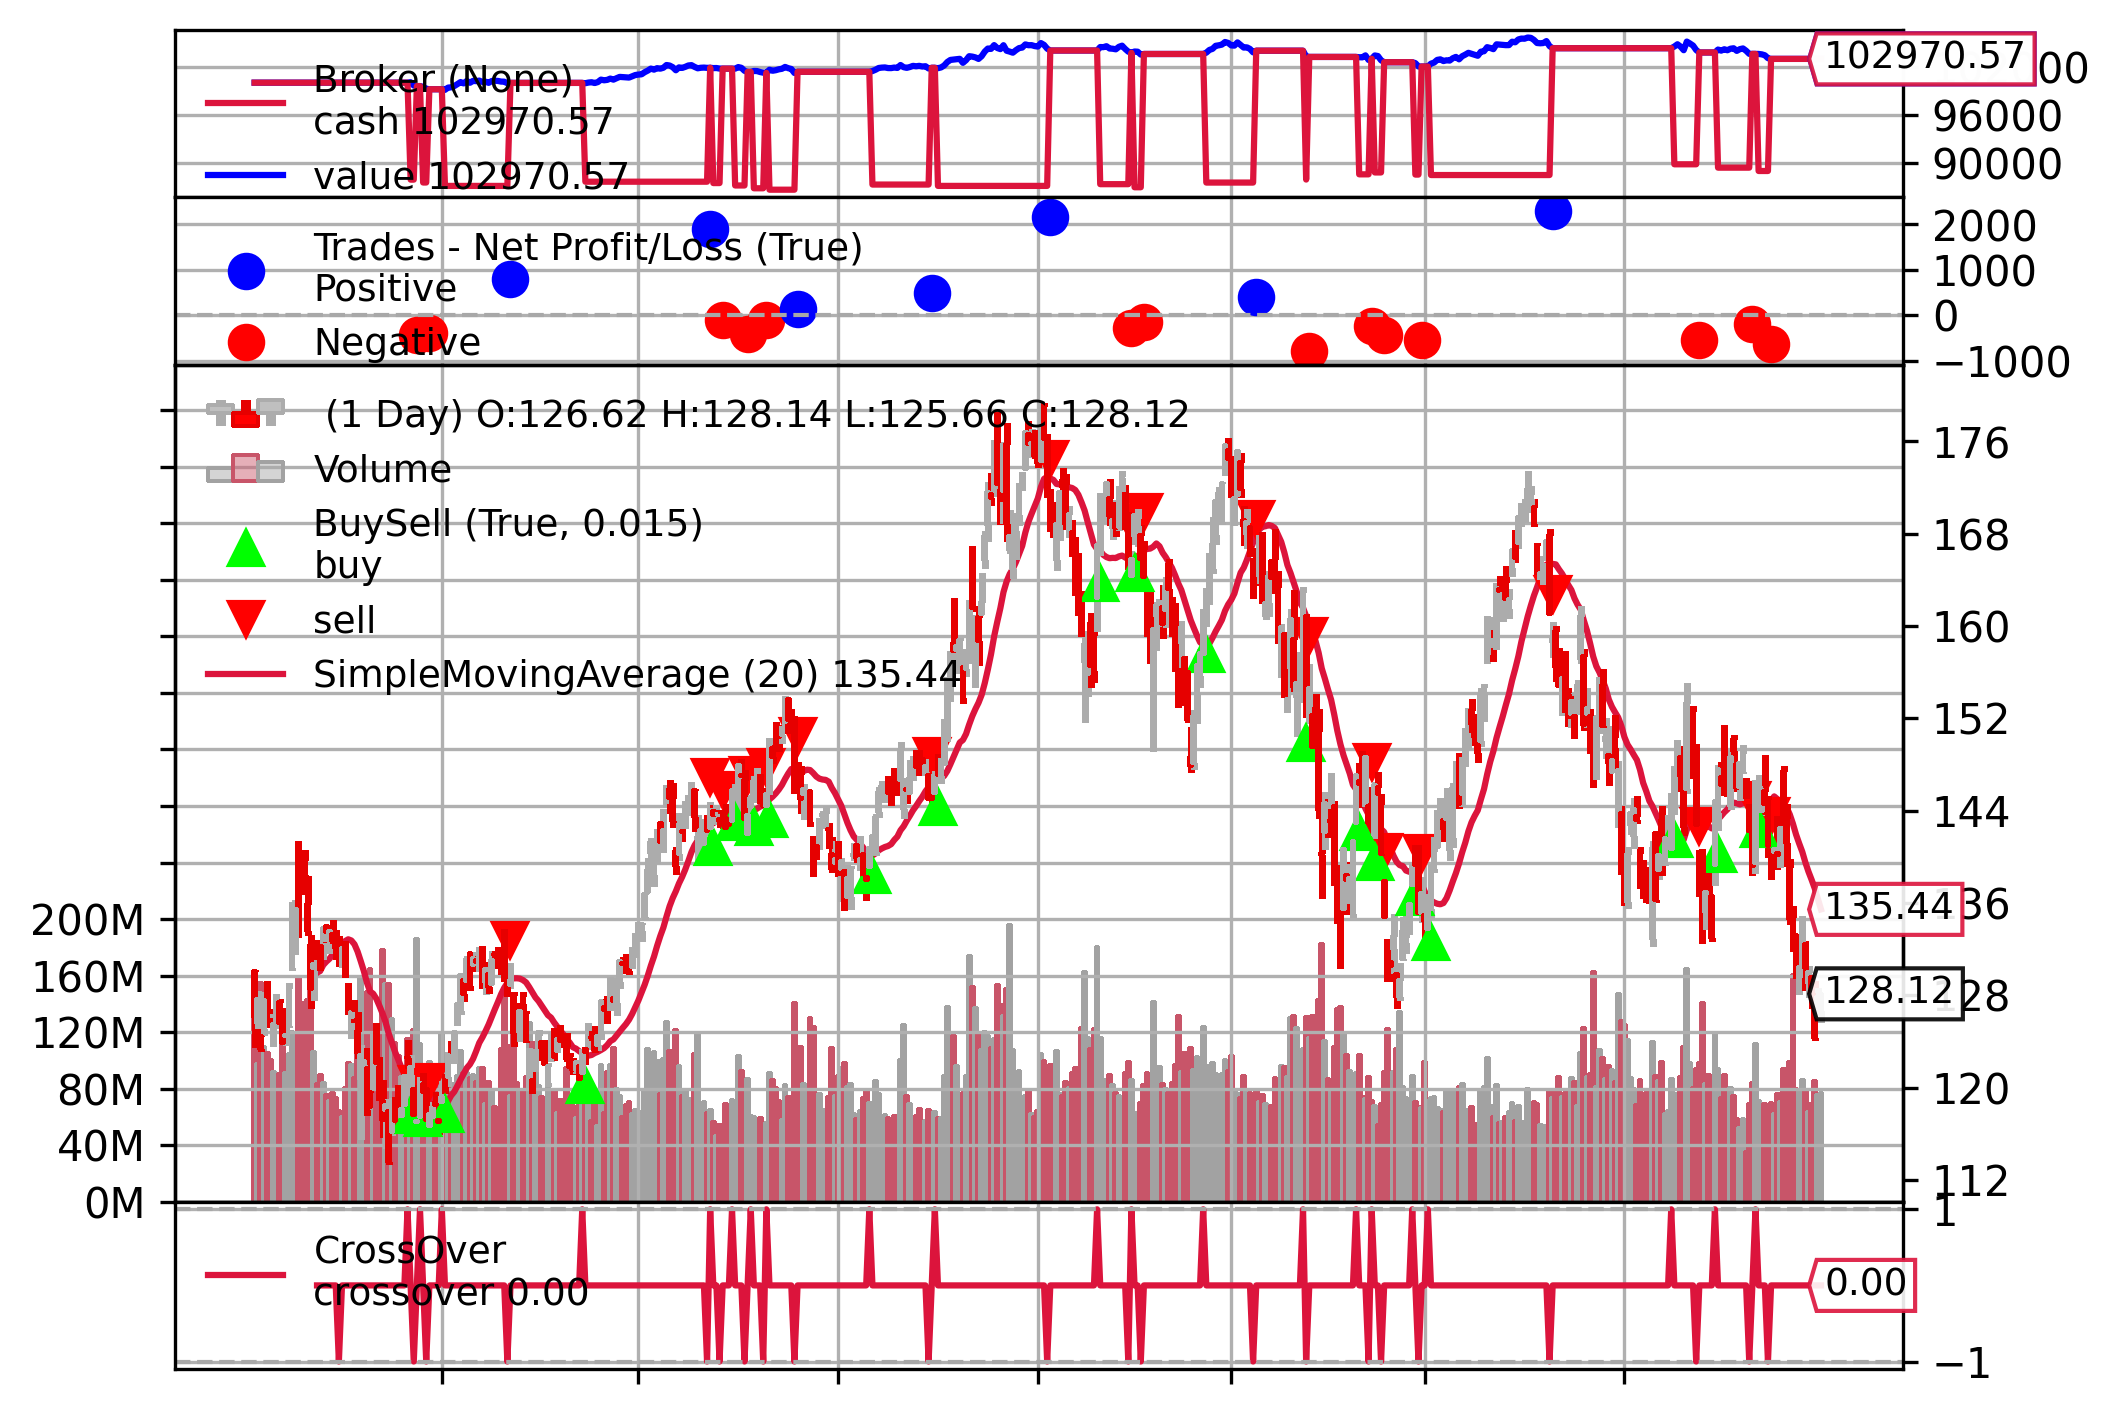

In [7]:

# Preview outputs in notebook
from IPython.display import display, Image

# Show first 5 trade rows (if any)
if not trades_df.empty:
    display(trades_df.head())

# Show saved chart inline
if os.path.exists(chart_path):
    display(Image(filename=chart_path))
else:
    print("Chart file not found (it should be saved at:", chart_path, ")")
